In [18]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from matplotlib import pyplot as plt
from matplotlib import patches
import plotly.graph_objects as go
import plotly.express as px

In [19]:
cats = []
adj = []
base_path = '../data/mit_states/release_dataset/'
for fl in (os.listdir(base_path + 'images/')):
    if os.path.isdir(base_path + 'images/' + fl):
        cats.append(fl.split(' ')[1])
        adj.append(fl.split(' ')[0])

print(len(cats))
print(len(adj))

2207
2207


In [20]:
desc_dict = {}
for i in range(len(cats)):
    if cats[i] in desc_dict:
        desc_dict[cats[i]].append(adj[i])
    else:
        desc_dict[cats[i]] = [adj[i]]
print(len(desc_dict.keys()))

245


In [21]:
adj_ants = pd.DataFrame(columns=['adjective', 'antonyms'])
with open(base_path + 'adj_ants.csv') as f:
    for line in f:
        adj = line.split(',')[0].strip()
        ants = line.split(',')[1:]
        ants = [ant.strip() for ant in ants if ant.strip()]
        adj_ants = pd.concat([adj_ants, pd.DataFrame({'adjective': adj, 'antonyms': ants})], ignore_index=True)
adj_ants.head()

,adjective,antonyms
0,ancient,modern
1,barren,verdant
2,bent,straight
3,blunt,sharp
4,bright,dark


In [22]:
# show adjective 'straight' row
adj_ants[adj_ants['adjective'] == 'straight']

,adjective,antonyms
59,straight,winding
60,straight,bent
61,straight,curved


In [23]:
cols = ['category', 'adj', 'image']
df = pd.DataFrame(columns=cols)

In [24]:
# for _dir in os.listdir(base_path + 'images/'):
#     if os.path.isdir(base_path + 'images/' + _dir):
#         for _file in os.listdir(base_path + 'images/' + _dir):
#             if _file.endswith('.jpg'):
#                 df = pd.concat([df, pd.DataFrame([[_dir.split(" ")[1], _dir.split(" ")[0], (base_path + 'images/' + _dir + '/' + _file)]], columns=cols)], ignore_index=True)
# df.head()

In [25]:
# dump the dataframe to a csv file
# df.to_csv(base_path + 'mit_states.csv', index=False)

In [26]:
# load dataset
df = pd.read_csv(base_path + 'mit_states.csv')
df.head()

,category,adj,image
0,elephant,old,../data/mit_states/release_dataset/images/old ...
1,elephant,old,../data/mit_states/release_dataset/images/old ...
2,elephant,old,../data/mit_states/release_dataset/images/old ...
3,elephant,old,../data/mit_states/release_dataset/images/old ...
4,elephant,old,../data/mit_states/release_dataset/images/old ...


(256, 256)


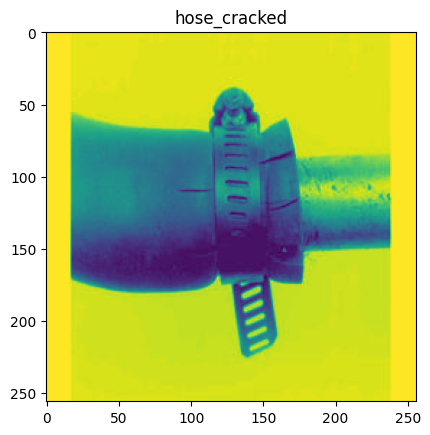

In [27]:
idx = random.randint(0, len(df))
# show a random image with its category and adjective
img = plt.imread(df['image'][idx])
print(img.shape)
plt.imshow(img)
plt.title(df['category'][idx] + '_' + df['adj'][idx])
plt.show()

In [28]:
# /home/smbh/.cache/torch/hub/checkpoints/
# https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#fasterrcnn-resnet50-fpn

# FasterRCNN RESNET50 Feature Extractor
class FasterRCNNFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FasterRCNNFeatureExtractor, self).__init__()
        self.model = model
        self.model.eval()
        self.model.roi_heads = nn.Identity()

    def forward(self, x):
        return self.model(x)

In [29]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
model = fasterrcnn_resnet50_fpn(
    weights='DEFAULT',
    num_classes=91,
    weights_backbone='DEFAULT',
    trainable_backbone_layers=0,
)
# model = FasterRCNNFeatureExtractor(model)
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

(256, 256, 3)


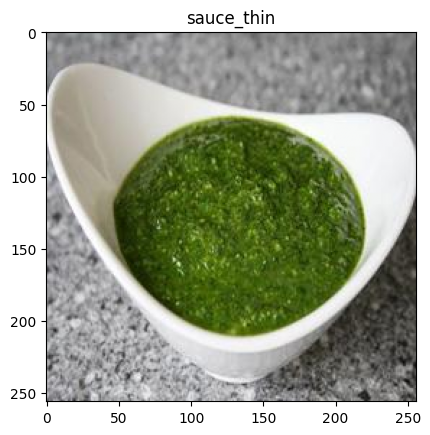

In [31]:
idx = random.randint(0, len(df))
img = plt.imread(df['image'][idx])
cat = df['category'][idx]
adj = df['adj'][idx]
img = img / 255.0
print(img.shape)
plt.imshow(img)
plt.title(df['category'][idx] + '_' + df['adj'][idx])
plt.show()

In [32]:
# For inference
# x = [torch.rand(3, 300, 400).cuda(), torch.rand(3, 500, 400).cuda()]
# x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
x = [torch.from_numpy(img).permute(2, 0, 1).float().to(device),]
preds = model(x)
preds

[{'boxes': tensor([[ 19.2849,  39.2120, 252.4137, 242.0378],
          [ 49.7874,  63.6072, 217.3789, 207.8654],
          [ 51.9113,  63.7090, 218.0959, 212.1048],
          [ 37.3397,  49.1651, 239.1824, 232.1135],
          [132.6156,  66.2820, 256.0000, 256.0000],
          [190.2283,  88.8038, 256.0000, 200.8594],
          [  0.0000, 142.0429, 256.0000, 256.0000],
          [  0.0000,   0.4258, 256.0000, 170.2176],
          [  0.0000,  55.6233, 108.7326, 251.4826]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([51, 53, 55, 47, 67, 67, 67, 67, 67], device='cuda:0'),
  'scores': tensor([0.9741, 0.3228, 0.2712, 0.1213, 0.1058, 0.0791, 0.0737, 0.0560, 0.0506],
         device='cuda:0', grad_fn=<IndexBackward0>)}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


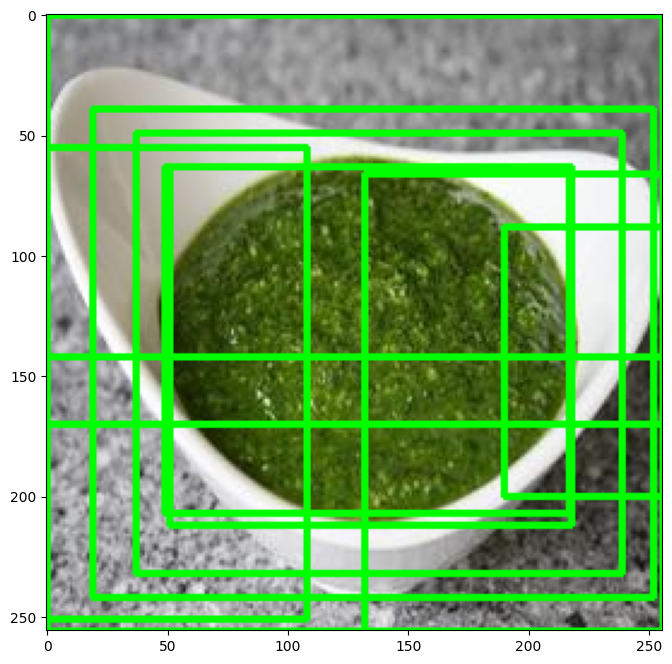

In [33]:
# show x[0] with bounding boxes
img_with_boxes = x[0].permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, figsize=(16, 8))
for box in preds[0]['boxes']:
    box = box.cpu().detach().numpy().astype(np.int32)
    cv2.rectangle(img_with_boxes, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
ax.imshow(img_with_boxes)
plt.show()

In [34]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
# dict of labels
labels = {i: weights.meta["categories"][i] for i in range(1, 91)}
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'N/A',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 26: 'N/A',
 27: 'backpack',
 28: 'umbrella',
 29: 'N/A',
 30: 'N/A',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 45: 'N/A',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 66: 'N/A'

In [35]:
for i in range(len(preds[0]["labels"])):
    lbl = preds[0]["labels"][i].item()
    tag = labels.get(lbl)
    score = preds[0]["scores"][i].item()
    print(lbl, tag, score)

51 bowl 0.9741392135620117
53 apple 0.32275208830833435
55 orange 0.27115195989608765
47 cup 0.12131145596504211
67 dining table 0.10583701729774475
67 dining table 0.07907070964574814
67 dining table 0.07367052137851715
67 dining table 0.05598093941807747
67 dining table 0.05063017085194588


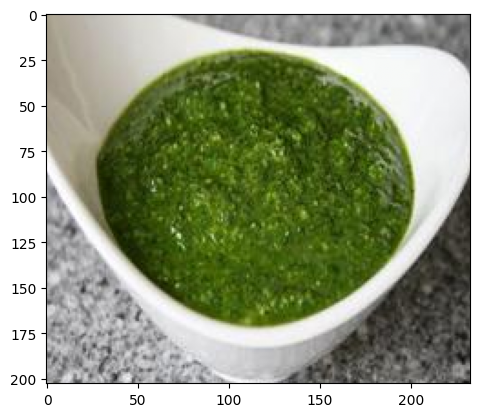

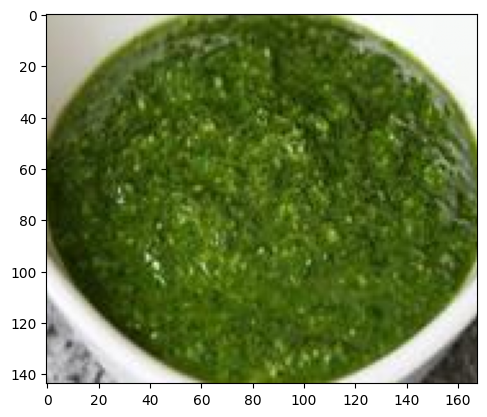

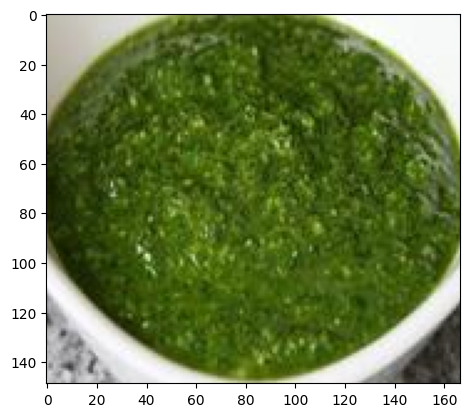

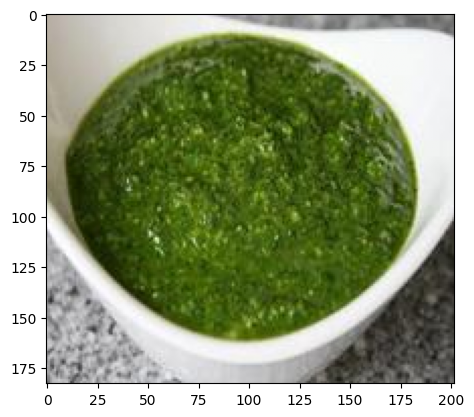

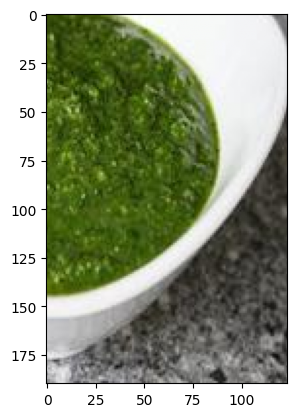

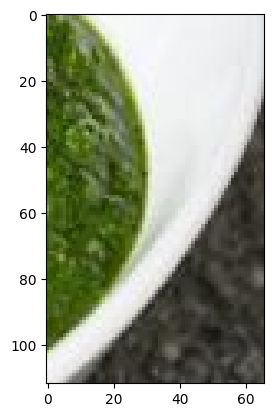

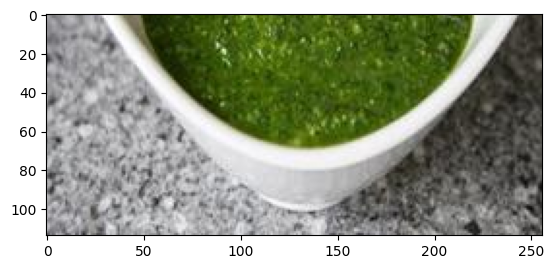

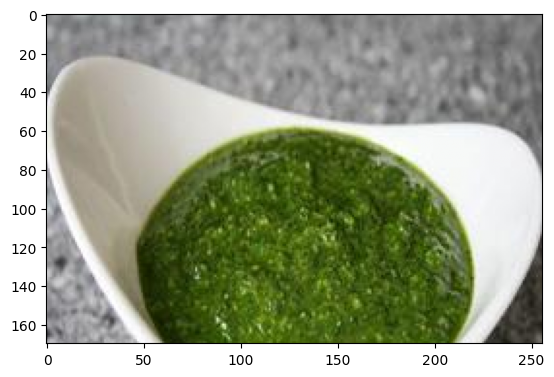

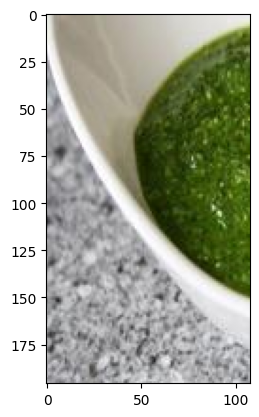

In [36]:
# crop the image with bounding boxes
for box in preds[0]['boxes']:
    box = box.cpu().detach().numpy().astype(np.int32)
    crop = img[box[1]:box[3], box[0]:box[2]]
    plt.imshow(crop)
    plt.show()

In [37]:
# add boxes col to df
df['boxes'] = None
print(df.head())

   category  adj                                              image boxes
0  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
1  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
2  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
3  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
4  elephant  old  ../data/mit_states/release_dataset/images/old ...  None


In [ ]:
max_boxed_size = (0, 0)
# go through all the images and crop them
for idx in range(len(df)):
    img = plt.imread(df['image'][idx])
    cat = df['category'][idx]
    adj = df['adj'][idx]
    img = img / 255.0
    try:
        x = [torch.from_numpy(img).permute(2, 0, 1).float().to(device),]
    except Exception as e:
        print(e)
        print(f"{idx}. {cat} {adj} - {img.shape}")
        print(img.shape)
        continue
    preds = model(x)
    this_boxes = []
    for box in preds[0]['boxes']:
        box = box.cpu().detach().numpy().astype(np.int32)
        crop = img[box[1]:box[3], box[0]:box[2]]
        # cv2.imwrite(base_path + 'images/' + cat + '_' + adj + '/' + str(idx) + '.jpg', crop)
        this_boxes.append(crop)
        # check crop size
        if crop.shape[0] > max_boxed_size[0] or crop.shape[1] > max_boxed_size[1]:
            max_boxed_size = crop.shape
    df['boxes'][idx] = this_boxes

In [ ]:
# padding all boxes to max_boxed_size
for idx in range(len(df)):
    this_boxes = df['boxes'][idx]
    for i in range(len(this_boxes)):
        this_boxes[i] = cv2.copyMakeBorder(this_boxes[i], 0, max_boxed_size[0] - this_boxes[i].shape[0], 0, max_boxed_size[1] - this_boxes[i].shape[1], cv2.BORDER_CONSTANT, value=[0, 0, 0])
    df['boxes'][idx] = this_boxes